In [ ]:
import requests, zipfile, io
import cv2
import glob
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image
import os 
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import keras
import tensorflow as tf
import random
from keras.utils import to_categorical
from google.colab import drive,files
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Set the seed for TensorFlow
tf.random.set_seed(1)
# Set the seed for NumPy
np.random.seed(1)
# Set the seed for the Python random module
random.seed(1)

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**storing data to google cloud**
(Code to be run only once)

In [ ]:
# os.mkdir('gdrive/MyDrive/data')
# os.mkdir('gdrive/MyDrive/data/Resized-cocci-224')
# os.mkdir('gdrive/MyDrive/data/Resized-healthy-224')
# os.mkdir('gdrive/MyDrive/data/Resized-salmo-224')

In [ ]:
#r = requests.get("https://zenodo.org/record/4628934/files/cocci.zip")
#z = zipfile.ZipFile(io.BytesIO(r.content))
#z.extractall('gdrive/MyDrive/data')

In [ ]:
#r = requests.get("https://zenodo.org/record/4628934/files/healthy.zip")
#z = zipfile.ZipFile(io.BytesIO(r.content))
#z.extractall('gdrive/MyDrive/data')

In [ ]:
#r = requests.get("https://zenodo.org/record/4628934/files/salmo.zip")
#z = zipfile.ZipFile(io.BytesIO(r.content))
#z.extractall('gdrive/MyDrive/data')

In [ ]:
#r = requests.get("https://zenodo.org/record/4628934/files/ncd.zip")
#z = zipfile.ZipFile(io.BytesIO(r.content))
#z.extractall('gdrive/MyDrive/data')

In [ ]:
#def resize(folder,save_to):
#  i= 0
#  images = glob.glob(folder + "/*.jpg")
#  for img in  images[:500]:
#    image= Image.open(img)
#    image= image.resize((224,224))
#    image.save(f"{save_to}/resized{i}.jpg")
#    i+=1
#  print(f'successfully saved to {save_to}')

In [ ]:
#resize('gdrive/MyDrive/data/salmo','gdrive/MyDrive/data/Resized-salmo-224')
#resize('gdrive/MyDrive/data/healthy','gdrive/MyDrive/data/Resized-healthy-224')
#resize('gdrive/MyDrive/data/cocci','gdrive/MyDrive/data/Resized-cocci-224')

successfully saved to gdrive/MyDrive/data/Resized-salmo-224
successfully saved to gdrive/MyDrive/data/Resized-healthy-224
successfully saved to gdrive/MyDrive/data/Resized-cocci-224


Reading data from google cloud 

In [ ]:
# We will take only 500 images of each class 
cocci = glob.glob('/content/gdrive/MyDrive/data/Resized-cocci/*.jpg')[:500]
healthy = glob.glob('/content/gdrive/MyDrive/data/Resized-healthy/*.jpg')[:500]
salmo = glob.glob('/content/gdrive/MyDrive/data/Resized-salmo/*.jpg')[:500]

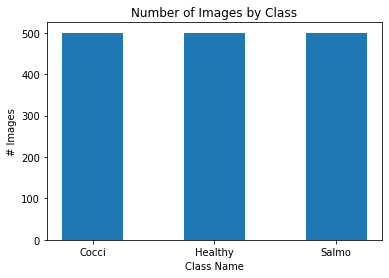

In [ ]:
dict_ = {"Cocci":len(cocci) ,
         "Healthy":len(healthy),
         "Salmo":len(salmo)}
plt.bar(dict_.keys(), dict_.values(), width = .5)
plt.title("Number of Images by Class")
plt.xlabel('Class Name');
plt.ylabel('# Images');
plt.show()

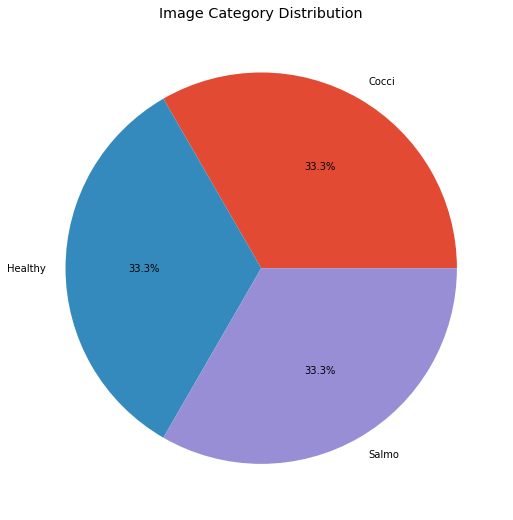

In [ ]:
labels = dict_.keys()
targets = dict_.values()
plt.style.use("ggplot")
plt.figure(figsize=(16, 9))
plt.pie(x=targets, labels=labels, autopct="%1.1f%%")
plt.title("Image Category Distribution")
plt.show()

Prepare data for training 

In [ ]:
labels = []
data =[] 

In [ ]:
def prepare_images(array,class_no):
  for img in array:
    x = load_img(img)
    x = img_to_array(x)
    data.append(x)
    labels.append(class_no)

In [ ]:
prepare_images(cocci,0)
prepare_images(healthy,1)
prepare_images(salmo,2)

In [ ]:
data = np.array(data)
labels = to_categorical(labels)

In [ ]:
X_train, X_test, ytrain, ytest = train_test_split(data, labels, test_size=0.2, random_state=1,shuffle=True)

Transfer Learning

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),include_top=False, # Transfer learning
                                                weights="imagenet")

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# freeze the base model 
base_model.trainable = False

In [ ]:
# Add a classification head
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,422,339
Trainable params: 164,355
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='best_model_tl.h5', monitor='val_accuracy', save_best_only=True, mode='max')

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-3),  metrics=['accuracy'])

In [ ]:
history = model.fit(
    X_train,ytrain,epochs=100,batch_size=32,validation_data=(X_test, ytest),callbacks=[early_stopping,model_checkpoint])

Epoch 1/100
38/38 [==============================] - 14s 110ms/step - loss: 0.5410 - accuracy: 0.7975 - val_loss: 0.2989 - val_accuracy: 0.8933
Epoch 2/100
38/38 [==============================] - 2s 64ms/step - loss: 0.3078 - accuracy: 0.8858 - val_loss: 0.2721 - val_accuracy: 0.9067
Epoch 3/100
38/38 [==============================] - 2s 57ms/step - loss: 0.2647 - accuracy: 0.8992 - val_loss: 0.2962 - val_accuracy: 0.8800
Epoch 4/100
38/38 [==============================] - 2s 58ms/step - loss: 0.2268 - accuracy: 0.9150 - val_loss: 0.2906 - val_accuracy: 0.8933
Epoch 5/100
38/38 [==============================] - 2s 65ms/step - loss: 0.2058 - accuracy: 0.9200 - val_loss: 0.2327 - val_accuracy: 0.8967
Epoch 6/100
38/38 [==============================] - 2s 60ms/step - loss: 0.1831 - accuracy: 0.9325 - val_loss: 0.2397 - val_accuracy: 0.9000
Epoch 7/100
38/38 [==============================] - 2s 64ms/step - loss: 0.1595 - accuracy: 0.9375 - val_loss: 0.2312 - val_accuracy: 0.9100
Epoc

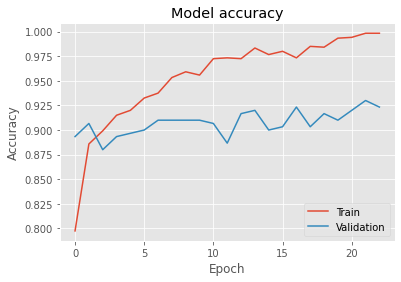

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
# load the best model
best_model_tl = keras.models.load_model('best_model_tl.h5')

In [ ]:
# Get predictions
y_pred = best_model_tl.predict(X_test)

# Convert predictions to class labels
y_pred_class = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_class = np.argmax(ytest, axis=1)

# Get confusion matrix
confusion_mat = confusion_matrix(y_true_class, y_pred_class)
print("\n--- Confusion Matrix ---\n")
print(confusion_mat)
# Get classification report
classification = classification_report(y_true_class, y_pred_class)
print("\n\n\t\t--- Classification Report ---\n")
print(classification)

10/10 [==============================] - 1s 47ms/step

--- Confusion Matrix ---

[[ 89   1   5]
 [  0 103   4]
 [  6   5  87]]


		--- Classification Report ---

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        95
           1       0.94      0.96      0.95       107
           2       0.91      0.89      0.90        98

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



Fine-tuning 

In [ ]:
# Unfreeze some layers in the base model
base_model.trainable = True

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4),  metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='best_model_fn.h5', monitor='val_accuracy', save_best_only=True, mode='max')

In [ ]:
history = model.fit(
    X_train,ytrain,epochs=100,batch_size=32,validation_data=(X_test, ytest),callbacks=[early_stopping,model_checkpoint])

Epoch 1/100
38/38 [==============================] - 16s 264ms/step - loss: 0.7003 - accuracy: 0.8600 - val_loss: 3.0860 - val_accuracy: 0.5233
Epoch 2/100
38/38 [==============================] - 8s 215ms/step - loss: 0.0667 - accuracy: 0.9783 - val_loss: 6.3585 - val_accuracy: 0.3467
Epoch 3/100
38/38 [==============================] - 8s 215ms/step - loss: 0.0319 - accuracy: 0.9883 - val_loss: 5.2409 - val_accuracy: 0.3733
Epoch 4/100
38/38 [==============================] - 9s 230ms/step - loss: 0.0461 - accuracy: 0.9867 - val_loss: 2.9964 - val_accuracy: 0.5467
Epoch 5/100
38/38 [==============================] - 8s 215ms/step - loss: 0.0279 - accuracy: 0.9900 - val_loss: 3.6007 - val_accuracy: 0.5367
Epoch 6/100
38/38 [==============================] - 8s 214ms/step - loss: 0.0251 - accuracy: 0.9917 - val_loss: 3.6167 - val_accuracy: 0.5367
Epoch 7/100
38/38 [==============================] - 8s 217ms/step - loss: 0.0360 - accuracy: 0.9892 - val_loss: 3.5510 - val_accuracy: 0.536

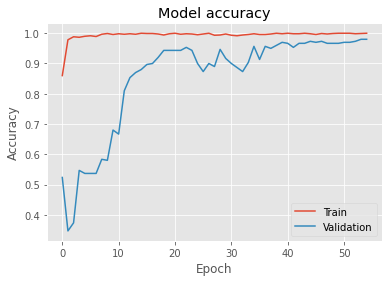

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
# load the best model
best_model_fn = keras.models.load_model('best_model_fn.h5')

In [ ]:
# Get predictions
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_class = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_class = np.argmax(ytest, axis=1)

# Get confusion matrix
confusion_mat = confusion_matrix(y_true_class, y_pred_class)
print("\n--- Confusion Matrix ---\n")
print(confusion_mat)
# Get classification report
classification_report = classification_report(y_true_class, y_pred_class)
print("\n\n\t\t--- Classification Report ---\n")
print(classification_report)


10/10 [==============================] - 1s 46ms/step

--- Confusion Matrix ---

[[ 94   0   1]
 [  0 104   3]
 [  0   2  96]]


		--- Classification Report ---

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        95
           1       0.98      0.97      0.98       107
           2       0.96      0.98      0.97        98

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300

